### Step 1: Importing the Relevant Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MaxAbsScaler,StandardScaler,Normalizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import MaxAbsScaler,StandardScaler,Normalizer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, KFold,cross_val_score,StratifiedKFold,cross_validate

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

### Step 2: Data Inspection

In [2]:
train = pd.read_csv("train_s3TEQDk.csv")
test = pd.read_csv("test_mSzZ8RL.csv")

In [3]:
train['Avg_Monthly_acc_balance_log']=np.log(train['Avg_Account_Balance']/train['Vintage'])

# train['Avg_Monthly_acc_balance_sqrt']=np.sqrt(train['Avg_Account_Balance']/train['Vintage'])
# train['Avg_Monthly_acc_balance_sqrt']=np.sqrt(train['Avg_Account_Balance']/train['Vintage'])

In [4]:
test['Avg_Monthly_acc_balance_log']=np.log(test['Avg_Account_Balance']/test['Vintage'])
# test['Avg_Monthly_acc_balance_sqrt']=np.sqrt(test['Avg_Account_Balance']/test['Vintage'])
# test['Avg_Monthly_acc_balance_sqrt']=np.sqrt(test['Avg_Account_Balance']/test['Vintage'])

In [5]:


# train['Tenured_balance_log']=np.log(train['Avg_Account_Balance']*train['Vintage'])
# test['Tenured_balance_log']=np.log(test['Avg_Account_Balance']*test['Vintage'])

In [6]:
# train['Credit_Product_Missing']=np.where(train['Credit_Product'].isnull(),1,0)
# test['Credit_Product_Missing']=np.where(test['Credit_Product'].isnull(),1,0)

In [7]:
train['Credit_Product'] = train['Credit_Product'].fillna("NA")
test['Credit_Product'] = test['Credit_Product'].fillna("NA")

In [8]:
from feature_engine.encoding import RareLabelEncoder
train_rare=train[['Region_Code']]
test_rare=test[['Region_Code']]
rare_encoder = RareLabelEncoder(
    tol=0.0099,  # minimal percentage to be considered non-rare
    n_categories=20, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=['Region_Code'] # variables to re-group
)
train['Region_Code']=rare_encoder.fit_transform(train_rare)
test['Region_Code']=rare_encoder.transform(test_rare)

In [9]:
train['Region_Code'].unique()

array(['RG268', 'RG277', 'RG270', 'RG282', 'RG261', 'Rare', 'RG283',
       'RG254', 'RG269', 'RG257', 'RG279', 'RG280', 'RG252', 'RG284',
       'RG259', 'RG281', 'RG260', 'RG274', 'RG256', 'RG275', 'RG273',
       'RG272', 'RG251', 'RG264', 'RG276', 'RG263', 'RG250'], dtype=object)

In [10]:
def value_count(col):
    return train[col].value_counts()*100/len(train),test[col].value_counts()*100/len(test)

In [11]:
from sklearn.preprocessing import LabelEncoder
ole = LabelEncoder()
ole.fit(train['Gender'])
train['Gender'] = ole.transform(train['Gender'])
test['Gender'] = ole.transform(test['Gender'])

In [12]:
from sklearn.preprocessing import LabelEncoder
ole = LabelEncoder()
ole.fit(train['Occupation'])
train['Occupation'] = ole.transform(train['Occupation'])
test['Occupation'] = ole.transform(test['Occupation'])

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['Channel_Code'])
train['Channel_Code'] = le.transform(train['Channel_Code'])
test['Channel_Code'] = le.transform(test['Channel_Code'])


In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['Credit_Product'])
train['Credit_Product'] = le.transform(train['Credit_Product'])
test['Credit_Product'] = le.transform(test['Credit_Product'])

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['Is_Active'])
train['Is_Active'] = le.transform(train['Is_Active'])
test['Is_Active'] = le.transform(test['Is_Active'])

In [16]:
# dicto = train['Region_Code'].value_counts(normalize=True).to_dict()
# train['Region_Code'] = train['Region_Code'].map(dicto)
# dicto = test['Region_Code'].value_counts(normalize=True).to_dict()
# test['Region_Code'] = test['Region_Code'].map(dicto)

In [17]:
from scipy import stats
fitted_data, fitted_lambda = stats.boxcox(np.abs(train['Vintage']))
train['Vintage_boxcox'] = fitted_data
fitted_data, fitted_lambda = stats.boxcox(np.abs(test['Vintage']))
test['Vintage_boxcox'] = fitted_data

In [18]:
train['Vintage_log'] = np.log(train['Vintage'])
test['Vintage_log'] = np.log(test['Vintage'])

In [19]:
# from sklearn.preprocessing import KBinsDiscretizer
# est = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
# est.fit(train['Avg_Account_Balance'].values.reshape(-1,1))
# train['Avg_Account_Balance_8_bins'] = est.transform(train['Avg_Account_Balance'].values.reshape(-1,1)).astype(int)
# test['Avg_Account_Balance_8_bins'] = est.transform(test['Avg_Account_Balance'].values.reshape(-1,1)).astype(int)

In [20]:
train.Region_Code=train.Region_Code.astype('category').cat.codes
test.Region_Code=test.Region_Code.astype('category').cat.codes

In [21]:
train['Avg_Account_Balance_log']=np.log(train['Avg_Account_Balance'])
test['Avg_Account_Balance_log']=np.log(test['Avg_Account_Balance'])

In [22]:
train['Avg_acc_bal_per_month']=train['Avg_Account_Balance_log']/ train['Vintage_log']
test['Avg_acc_bal_per_month']=test['Avg_Account_Balance_log']/ test['Vintage_log']

In [23]:
train['Avg_Account_Balance_sqrt']=np.sqrt(train['Avg_Account_Balance'])
test['Avg_Account_Balance_sqrt']=np.sqrt(test['Avg_Account_Balance'])

In [24]:
from feature_engine.discretisation import EqualWidthDiscretiser,EqualFrequencyDiscretiser
disca = EqualFrequencyDiscretiser(q=5)
disc = EqualFrequencyDiscretiser(q=10)
disc1=EqualFrequencyDiscretiser(q=20)
disc2=EqualFrequencyDiscretiser(q=30)
disc01 = EqualFrequencyDiscretiser(q=10)
disc11=EqualFrequencyDiscretiser(q=20)
disc21=EqualFrequencyDiscretiser(q=30)
disc31=EqualFrequencyDiscretiser(q=50)
train['Avg_acc_bal_10_bins']=disc01.fit_transform(train[['Avg_Account_Balance_log']])
test['Avg_acc_bal_10_bins']=disc01.transform(test[['Avg_Account_Balance_log']])
train['Avg_acc_bal_20_bins']=disc11.fit_transform(train[['Avg_Account_Balance_log']])
test['Avg_acc_bal_20_bins']=disc11.transform(test[['Avg_Account_Balance_log']])
train['Avg_acc_bal_30_bins']=disc21.fit_transform(train[['Avg_Account_Balance_log']])
test['Avg_acc_bal_30_bins']=disc21.transform(test[['Avg_Account_Balance_log']])
train['Avg_acc_bal_50_bins']=disc31.fit_transform(train[['Avg_Account_Balance_log']])
test['Avg_acc_bal_50_bins']=disc31.transform(test[['Avg_Account_Balance_log']])
train['Age_5_bins']=disca.fit_transform(train[['Age']])
test['Age_5_bins']=disca.transform(test[['Age']])
train['Age_10_bins']=disc.fit_transform(train[['Age']])
test['Age_10_bins']=disc.transform(test[['Age']])
train['Age_20_bins']=disc1.fit_transform(train[['Age']])
test['Age_20_bins']=disc1.transform(test[['Age']])
train['Age_30_bins']=disc2.fit_transform(train[['Age']])
test['Age_30_bins']=disc2.transform(test[['Age']])


In [25]:
# sns.histplot(data=train,x='Age_20_bins',hue='Is_Lead')

In [26]:
def converter(column=str):
    return {i:train.loc[train[column]==i,"Is_Lead"].sum()/train.loc[train[column]==i,"Is_Lead"].count() for i in train[column].unique()}
def conv_relative(col):    
    return (train.loc[(train['Is_Lead']==1),col].value_counts() / len(train.loc[(train['Is_Lead']==1),col])).to_dict()

In [27]:
train['LeadConvRate_by_Age']=train['Age'].map(converter('Age'))
test['LeadConvRate_by_Age']=test['Age'].map(converter('Age'))
train['LeadConvRate_by_Vintage']=train['Vintage_log'].map(converter('Vintage_log'))
test['LeadConvRate_by_Vintage']=test['Vintage_log'].map(converter('Vintage_log'))
# train['LeadConvRate_by_Age_5_bins']=train['Age_5_bins'].map(converter('Age_5_bins'))
# test['LeadConvRate_by_Age_5_bins']=test['Age_5_bins'].map(converter('Age_5_bins'))
train['LeadConvRate_by_Age_10_bins']=train['Age_10_bins'].map(converter('Age_10_bins'))
test['LeadConvRate_by_Age_10_bins']=test['Age_10_bins'].map(converter('Age_10_bins'))
train['LeadConvRate_by_Age_20_bins']=train['Age_20_bins'].map(converter('Age_20_bins'))
test['LeadConvRate_by_Age_20_bins']=test['Age_20_bins'].map(converter('Age_20_bins'))
train['LeadConvRate_by_Age_30_bins']=train['Age_30_bins'].map(converter('Age_30_bins'))
test['LeadConvRate_by_Age_30_bins']=test['Age_30_bins'].map(converter('Age_30_bins'))
train['LeadConvRate_by_Region_Code']=train['Region_Code'].map(converter('Region_Code'))
test['LeadConvRate_by_Region_Code']=test['Region_Code'].map(converter('Region_Code'))
train['LeadConvRate_by_Occupation']=train['Occupation'].map(converter('Occupation'))
test['LeadConvRate_by_Occupation']=test['Occupation'].map(converter('Occupation'))
train['LeadConvRate_by_Active']=train['Is_Active'].map(converter('Is_Active'))
test['LeadConvRate_by_Active']=test['Is_Active'].map(converter('Is_Active'))
train['LeadConvRate_by_Gender']=train['Gender'].map(converter('Gender'))
test['LeadConvRate_by_Gender']=test['Gender'].map(converter('Gender'))
train['LeadConvRate_by_Credit_Product']=train['Credit_Product'].map(converter('Credit_Product'))
test['LeadConvRate_by_Credit_Product']=test['Credit_Product'].map(converter('Credit_Product'))
train['LeadConvRate_by_Channel_Code']=train['Channel_Code'].map(converter('Channel_Code'))
test['LeadConvRate_by_Channel_Code']=test['Channel_Code'].map(converter('Channel_Code'))
train['LeadConvRate_by_Avg_acc_bal_10_bins']=train['Avg_acc_bal_10_bins'].map(converter('Avg_acc_bal_10_bins'))
test['LeadConvRate_by_Avg_acc_bal_10_bins']=test['Avg_acc_bal_10_bins'].map(converter('Avg_acc_bal_10_bins'))
train['LeadConvRate_by_Avg_acc_bal_20_bins']=train['Avg_acc_bal_20_bins'].map(converter('Avg_acc_bal_20_bins'))
test['LeadConvRate_by_Avg_acc_bal_20_bins']=test['Avg_acc_bal_20_bins'].map(converter('Avg_acc_bal_20_bins'))
train['LeadConvRate_by_Avg_acc_bal_30_bins']=train['Avg_acc_bal_30_bins'].map(converter('Avg_acc_bal_30_bins'))
test['LeadConvRate_by_Avg_acc_bal_30_bins']=test['Avg_acc_bal_30_bins'].map(converter('Avg_acc_bal_30_bins'))
train['LeadConvRate_by_Avg_acc_bal_50_bins']=train['Avg_acc_bal_50_bins'].map(converter('Avg_acc_bal_50_bins'))
test['LeadConvRate_by_Avg_acc_bal_50_bins']=test['Avg_acc_bal_50_bins'].map(converter('Avg_acc_bal_50_bins'))

In [28]:
train['LeadConvRelativerate_by_Age']=train['Age'].map(conv_relative('Age'))
test['LeadConvRelativerate_by_Age']=test['Age'].map(conv_relative('Age'))
train['LeadConvRelativerate_by_Vintage']=train['Vintage_log'].map(conv_relative('Vintage_log'))
test['LeadConvRelativerate_by_Vintage']=test['Vintage_log'].map(conv_relative('Vintage_log'))
# train['LeadConvRelativerate_by_Age_5_bins']=train['Age_5_bins'].map(conv_relative('Age_5_bins'))
# test['LeadConvRelativerate_by_Age_5_bins']=test['Age_5_bins'].map(conv_relative('Age_5_bins'))
train['LeadConvRelativerate_by_Age_10_bins']=train['Age_10_bins'].map(conv_relative('Age_10_bins'))
test['LeadConvRelativerate_by_Age_10_bins']=test['Age_10_bins'].map(conv_relative('Age_10_bins'))
train['LeadConvRelativerate_by_Age_20_bins']=train['Age_20_bins'].map(conv_relative('Age_20_bins'))
test['LeadConvRelativerate_by_Age_20_bins']=test['Age_20_bins'].map(conv_relative('Age_20_bins'))
train['LeadConvRelativerate_by_Age_30_bins']=train['Age_30_bins'].map(conv_relative('Age_30_bins'))
test['LeadConvRelativerate_by_Age_30_bins']=test['Age_30_bins'].map(conv_relative('Age_30_bins'))
train['LeadConvRelativerate_by_Region_Code']=train['Region_Code'].map(conv_relative('Region_Code'))
test['LeadConvRelativerate_by_Region_Code']=test['Region_Code'].map(conv_relative('Region_Code'))
train['LeadConvRelativerate_by_Occupation']=train['Occupation'].map(conv_relative('Occupation'))
test['LeadConvRelativerate_by_Occupation']=test['Occupation'].map(conv_relative('Occupation'))
train['LeadConvRelativerate_by_Active']=train['Is_Active'].map(conv_relative('Is_Active'))
test['LeadConvRelativerate_by_Active']=test['Is_Active'].map(conv_relative('Is_Active'))
train['LeadConvRelativerate_by_Gender']=train['Gender'].map(conv_relative('Gender'))
test['LeadConvRelativerate_by_Gender']=test['Gender'].map(conv_relative('Gender'))
train['LeadConvRelativerate_by_Credit_Product']=train['Credit_Product'].map(conv_relative('Credit_Product'))
test['LeadConvRelativerate_by_Credit_Product']=test['Credit_Product'].map(conv_relative('Credit_Product'))
train['LeadConvRelativerate_by_Channel_Code']=train['Channel_Code'].map(conv_relative('Channel_Code'))
test['LeadConvRelativerate_by_Channel_Code']=test['Channel_Code'].map(conv_relative('Channel_Code'))
train['LeadConvRelativerate_by_Avg_acc_bal_10_bins']=train['Avg_acc_bal_10_bins'].map(conv_relative('Avg_acc_bal_10_bins'))
test['LeadConvRelativerate_by_Avg_acc_bal_10_bins']=test['Avg_acc_bal_10_bins'].map(conv_relative('Avg_acc_bal_10_bins'))
train['LeadConvRelativerate_by_Avg_acc_bal_20_bins']=train['Avg_acc_bal_20_bins'].map(conv_relative('Avg_acc_bal_20_bins'))
test['LeadConvRelativerate_by_Avg_acc_bal_20_bins']=test['Avg_acc_bal_20_bins'].map(conv_relative('Avg_acc_bal_20_bins'))
train['LeadConvRelativerate_by_Avg_acc_bal_30_bins']=train['Avg_acc_bal_30_bins'].map(conv_relative('Avg_acc_bal_30_bins'))
test['LeadConvRelativerate_by_Avg_acc_bal_30_bins']=test['Avg_acc_bal_30_bins'].map(conv_relative('Avg_acc_bal_30_bins'))
train['LeadConvRelativerate_by_Avg_acc_bal_50_bins']=train['Avg_acc_bal_50_bins'].map(conv_relative('Avg_acc_bal_50_bins'))
test['LeadConvRelativerate_by_Avg_acc_bal_50_bins']=test['Avg_acc_bal_50_bins'].map(conv_relative('Avg_acc_bal_50_bins'))

In [29]:
train['Avg_Acc_bal_by_region_code']=train.groupby(['Region_Code'])['Avg_Account_Balance_log'].transform('mean')
test['Avg_Acc_bal_by_region_code']=test.groupby(['Region_Code'])['Avg_Account_Balance_log'].transform('mean')
train['Avg_Acc_bal_by_region_code_min']=train.groupby(['Region_Code'])['Avg_Account_Balance_log'].transform('min')
test['Avg_Acc_bal_by_region_code_min']=test.groupby(['Region_Code'])['Avg_Account_Balance_log'].transform('min')
train['Avg_Acc_bal_by_region_code_max']=train.groupby(['Region_Code'])['Avg_Account_Balance_log'].transform('max')
test['Avg_Acc_bal_by_region_code_max']=test.groupby(['Region_Code'])['Avg_Account_Balance_log'].transform('max')
train['Avg_Acc_bal_by_region_code_std']=train.groupby(['Region_Code'])['Avg_Account_Balance_log'].transform('std')
test['Avg_Acc_bal_by_region_code_std']=test.groupby(['Region_Code'])['Avg_Account_Balance_log'].transform('std')

In [30]:
train['Avg_Acc_bal_by_vintage']=train.groupby(['Vintage_log'])['Avg_Account_Balance_log'].transform('mean')
test['Avg_Acc_bal_by_vintage']=test.groupby(['Vintage_log'])['Avg_Account_Balance_log'].transform('mean')
train['Avg_Acc_bal_by_vintage_min']=train.groupby(['Vintage_log'])['Avg_Account_Balance_log'].transform('min')
test['Avg_Acc_bal_by_vintage_min']=test.groupby(['Vintage_log'])['Avg_Account_Balance_log'].transform('min')
train['Avg_Acc_bal_by_vintage_max']=train.groupby(['Vintage_log'])['Avg_Account_Balance_log'].transform('max')
test['Avg_Acc_bal_by_vintage_max']=test.groupby(['Vintage_log'])['Avg_Account_Balance_log'].transform('max')
train['Avg_Acc_bal_by_vintage_std']=train.groupby(['Vintage_log'])['Avg_Account_Balance_log'].transform('std')
test['Avg_Acc_bal_by_vintage_std']=test.groupby(['Vintage_log'])['Avg_Account_Balance_log'].transform('std')

In [31]:
train['Avg_Acc_bal_by_Age']=train.groupby(['Age'])['Avg_Account_Balance_log'].transform('mean')
test['Avg_Acc_bal_by_Age']=test.groupby(['Age'])['Avg_Account_Balance_log'].transform('mean')
train['Avg_Acc_bal_by_Age_min']=train.groupby(['Age'])['Avg_Account_Balance_log'].transform('min')
test['Avg_Acc_bal_by_Age_min']=test.groupby(['Age'])['Avg_Account_Balance_log'].transform('min')
train['Avg_Acc_bal_by_Age_max']=train.groupby(['Age'])['Avg_Account_Balance_log'].transform('max')
test['Avg_Acc_bal_by_Age_max']=test.groupby(['Age'])['Avg_Account_Balance_log'].transform('max')

In [32]:
# train['Avg_Acc_bal_by_Age_5_bins']=train.groupby(['Age_5_bins'])['Avg_Account_Balance_log'].transform('mean')
# test['Avg_Acc_bal_by_Age_5_bins']=test.groupby(['Age_5_bins'])['Avg_Account_Balance_log'].transform('mean')
# train['Avg_Acc_bal_by_Age_5_bins_min']=train.groupby(['Age_5_bins'])['Avg_Account_Balance_log'].transform('min')
# test['Avg_Acc_bal_by_Age_5_bins_min']=test.groupby(['Age_5_bins'])['Avg_Account_Balance_log'].transform('min')
# train['Avg_Acc_bal_by_Age_5_bins_max']=train.groupby(['Age_5_bins'])['Avg_Account_Balance_log'].transform('max')
# test['Avg_Acc_bal_by_Age_5_bins_max']=test.groupby(['Age_5_bins'])['Avg_Account_Balance_log'].transform('max')

In [33]:
train['Avg_Acc_bal_by_Age_10_bins']=train.groupby(['Age_10_bins'])['Avg_Account_Balance_log'].transform('mean')
test['Avg_Acc_bal_by_Age_10_bins']=test.groupby(['Age_10_bins'])['Avg_Account_Balance_log'].transform('mean')
train['Avg_Acc_bal_by_Age_10_bins_min']=train.groupby(['Age_10_bins'])['Avg_Account_Balance_log'].transform('min')
test['Avg_Acc_bal_by_Age_10_bins_min']=test.groupby(['Age_10_bins'])['Avg_Account_Balance_log'].transform('min')
train['Avg_Acc_bal_by_Age_10_bins_max']=train.groupby(['Age_10_bins'])['Avg_Account_Balance_log'].transform('max')
test['Avg_Acc_bal_by_Age_10_bins_max']=test.groupby(['Age_10_bins'])['Avg_Account_Balance_log'].transform('max')

In [34]:
train['Avg_Acc_bal_by_Age_10_bins_std']=train.groupby(['Age_10_bins'])['Avg_Account_Balance_log'].transform('std')
test['Avg_Acc_bal_by_Age_10_bins_std']=test.groupby(['Age_10_bins'])['Avg_Account_Balance_log'].transform('std')
train['Avg_Acc_bal_by_Age_20_bins_std']=train.groupby(['Age_20_bins'])['Avg_Account_Balance_log'].transform('std')
test['Avg_Acc_bal_by_Age_20_bins_std']=test.groupby(['Age_20_bins'])['Avg_Account_Balance_log'].transform('std')
train['Avg_Acc_bal_by_Age_30_bins_std']=train.groupby(['Age_20_bins'])['Avg_Account_Balance_log'].transform('std')
test['Avg_Acc_bal_by_Age_30_bins_std']=test.groupby(['Age_20_bins'])['Avg_Account_Balance_log'].transform('std')

In [35]:
train['Avg_Acc_bal_by_Age_20_bins']=train.groupby(['Age_20_bins'])['Avg_Account_Balance_log'].transform('mean')
test['Avg_Acc_bal_by_Age_20_bins']=test.groupby(['Age_20_bins'])['Avg_Account_Balance_log'].transform('mean')
train['Avg_Acc_bal_by_Age_20_bins_min']=train.groupby(['Age_20_bins'])['Avg_Account_Balance_log'].transform('min')
test['Avg_Acc_bal_by_Age_20_bins_min']=test.groupby(['Age_20_bins'])['Avg_Account_Balance_log'].transform('min')
train['Avg_Acc_bal_by_Age_20_bins_max']=train.groupby(['Age_20_bins'])['Avg_Account_Balance_log'].transform('max')
test['Avg_Acc_bal_by_Age_20_bins_max']=test.groupby(['Age_20_bins'])['Avg_Account_Balance_log'].transform('max')

In [36]:
train['Avg_Acc_bal_by_Age_30_bins']=train.groupby(['Age_30_bins'])['Avg_Account_Balance_log'].transform('mean')
test['Avg_Acc_bal_by_Age_30_bins']=test.groupby(['Age_30_bins'])['Avg_Account_Balance_log'].transform('mean')
train['Avg_Acc_bal_by_Age_30_bins_min']=train.groupby(['Age_30_bins'])['Avg_Account_Balance_log'].transform('min')
test['Avg_Acc_bal_by_Age_30_bins_min']=test.groupby(['Age_30_bins'])['Avg_Account_Balance_log'].transform('min')
train['Avg_Acc_bal_by_Age_30_bins_max']=train.groupby(['Age_30_bins'])['Avg_Account_Balance_log'].transform('max')
test['Avg_Acc_bal_by_Age_30_bins_max']=test.groupby(['Age_30_bins'])['Avg_Account_Balance_log'].transform('max')

In [37]:
train['Avg_Acc_bal_by_Occupation']=train.groupby(['Occupation'])['Avg_Account_Balance_log'].transform('mean')
test['Avg_Acc_bal_by_Occupation']=test.groupby(['Occupation'])['Avg_Account_Balance_log'].transform('mean')
train['Avg_Acc_bal_by_Occupation_min']=train.groupby(['Occupation'])['Avg_Account_Balance_log'].transform('min')
test['Avg_Acc_bal_by_Occupation_min']=test.groupby(['Occupation'])['Avg_Account_Balance_log'].transform('min')
train['Avg_Acc_bal_by_Occupation_max']=train.groupby(['Occupation'])['Avg_Account_Balance_log'].transform('max')
test['Avg_Acc_bal_by_Occupation_max']=test.groupby(['Occupation'])['Avg_Account_Balance_log'].transform('max')
train['Avg_Acc_bal_by_Occupation_std']=train.groupby(['Occupation'])['Avg_Account_Balance_log'].transform('std')
test['Avg_Acc_bal_by_Occupation_std']=test.groupby(['Occupation'])['Avg_Account_Balance_log'].transform('std')

In [38]:
train['Avg_Acc_bal_by_Channel_Code']=train.groupby(['Channel_Code'])['Avg_Account_Balance_log'].transform('mean')
test['Avg_Acc_bal_by_Channel_Code']=test.groupby(['Channel_Code'])['Avg_Account_Balance_log'].transform('mean')
train['Avg_Acc_bal_by_Channel_Code_min']=train.groupby(['Channel_Code'])['Avg_Account_Balance_log'].transform('min')
test['Avg_Acc_bal_by_Channel_Code_min']=test.groupby(['Channel_Code'])['Avg_Account_Balance_log'].transform('min')
train['Avg_Acc_bal_by_Channel_Code_max']=train.groupby(['Channel_Code'])['Avg_Account_Balance_log'].transform('max')
test['Avg_Acc_bal_by_Channel_Code_max']=test.groupby(['Channel_Code'])['Avg_Account_Balance_log'].transform('max')
train['Avg_Acc_bal_by_Channel_Code_std']=train.groupby(['Channel_Code'])['Avg_Account_Balance_log'].transform('std')
test['Avg_Acc_bal_by_Channel_Code_std']=test.groupby(['Channel_Code'])['Avg_Account_Balance_log'].transform('std')

In [39]:
train=train.drop(columns=['Vintage','Avg_Account_Balance',"Age","Region_Code"])
test=test.drop(columns=['Vintage','Avg_Account_Balance','Age',"Region_Code"])

In [41]:
sample_submission = pd.read_csv('sample_submission_eyYijxG.csv')

In [42]:
train1=train.drop(columns=['ID'])
test1=test.drop(columns=['ID'])

In [43]:
train1['LeadConvRelativerate_by_Age']=train1['LeadConvRelativerate_by_Age'].fillna(0)

In [2102]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
%matplotlib inline

def model(train,test,model_name=None,modename='predmodel',sample_submission=pd.DataFrame()):
    pred='Is_Lead'
    print(test.shape)
    predictions = np.zeros(test.shape[0])
    oobs = np.zeros(train.shape[0])
    y = train[pred].values
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model = model_name
    X=train.drop(columns=['Is_Lead'])
    y=train['Is_Lead']
    X_test=test
    transformer = MinMaxScaler().fit(X)
    X = transformer.transform(X)
    X_test = transformer.transform(X_test)
    for i, (train_id, valid_id) in enumerate(skf.split(X,y)):
        X_train, y_train = X[train_id], y[train_id]
        X_valid, y_valid = X[valid_id], y[valid_id]
        model.fit(X_train, y_train, eval_set =[(X_valid, y_valid)],  early_stopping_rounds=200, verbose=1000, eval_metric='auc')
        oobs[valid_id] = model.predict_proba(X_valid)[:,1]
        predictions += model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y,oobs)
    if(roc_auc>87.5):
        L.append(predictions)
    finals = predictions/5
    lgb_predictions = finals
    sample_submission[pred] = finals
    print("ROC-AUC", roc_auc)
    lgb_oobs = oobs
    pd.DataFrame(data=oobs).to_csv('oob_lgb.csv')
    import matplotlib.pyplot as plt
    import seaborn as sns
    import warnings
    warnings.simplefilter(action='ignore')
    # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,train.drop(columns=['Is_Lead']))), columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    print(feature_imp)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    sample_submission.to_csv('model'+modename+'.csv', index=False)
    return feature_imp,L

In [2103]:
train['Is_Lead'].value_counts()

0    187437
1     58288
Name: Is_Lead, dtype: int64

In [2105]:
params = {
    'n_estimators':10000,
    'learning_rate': 0.1,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'metrics':'auc',
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.632,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.55,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':3.215704776283283 # because training data is extremely unbalanced 
}

(105312, 80)
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	valid_0's auc: 0.875646
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.873005
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.873643
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.875116
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	valid_0's auc: 0.874856
ROC-AUC 0.8743498721417224
    Value                                      Feature
0       0  LeadConvRelativerate_by_Avg_acc_bal_10_bins
1       1                   Avg_Acc_bal_by_Age_10_bins
2       1                          Avg_acc_bal_20_bins
3       1  LeadConvRelativerate_by_Avg_acc_bal_20_bins
4       1               LeadConvRelativerate_by_Gender


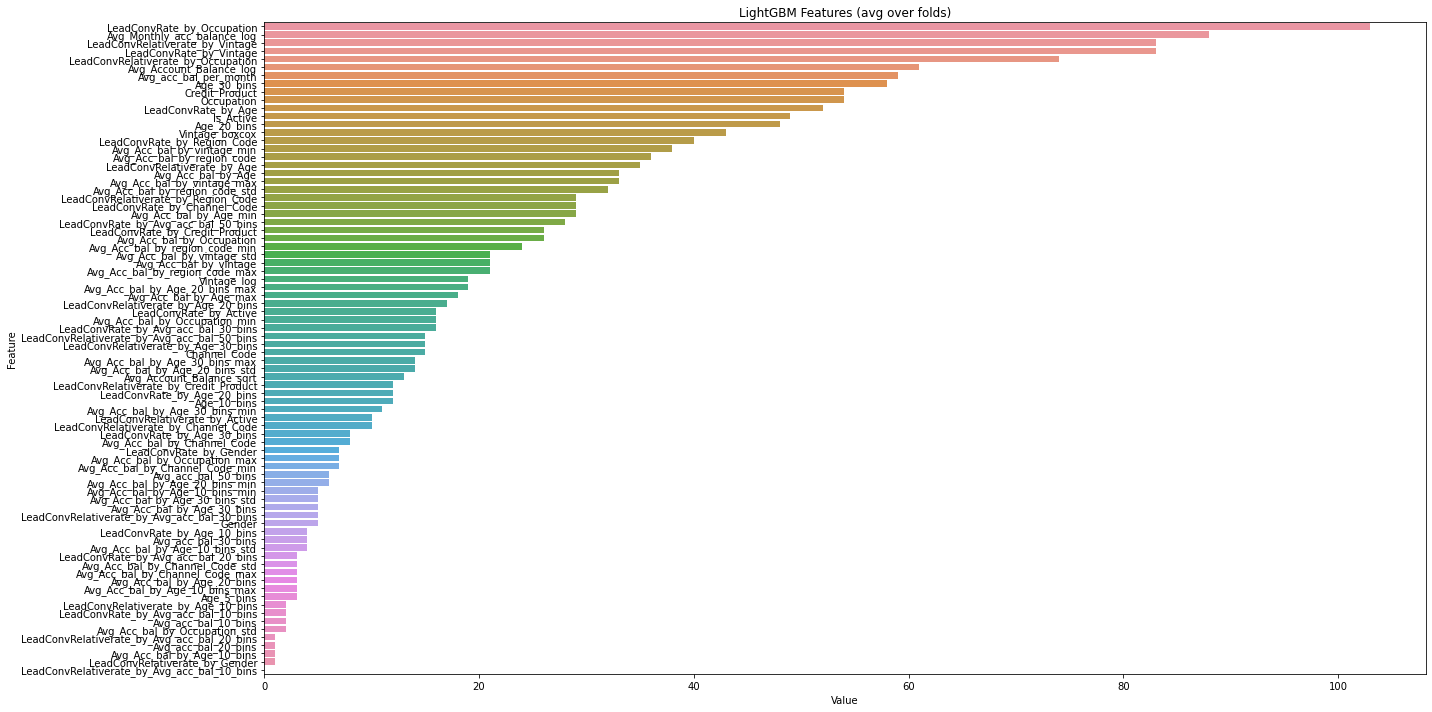

In [2106]:
params = {'scale_pos_weight':3.215704776283283,'n_estimators': 10000, 'n_jobs': -1, 'random_state': 2,'learning_rate': 0.1,'max_depth': -1,'subsample': 0.63, 'colsample_bytree': 0.55,'metric':'auc'}
res=model(train1,test1,LGBMClassifier(**params),'rawstdnew11',sample_submission)

In [2101]:
res

(    Value                                      Feature
 0       0  LeadConvRelativerate_by_Avg_acc_bal_10_bins
 1       1                   Avg_Acc_bal_by_Age_10_bins
 2       1                          Avg_acc_bal_20_bins
 3       1  LeadConvRelativerate_by_Avg_acc_bal_20_bins
 4       1               LeadConvRelativerate_by_Gender
 ..    ...                                          ...
 75     74           LeadConvRelativerate_by_Occupation
 76     83                      LeadConvRate_by_Vintage
 77     83              LeadConvRelativerate_by_Vintage
 78     88                  Avg_Monthly_acc_balance_log
 79    103                   LeadConvRate_by_Occupation
 
 [80 rows x 2 columns],
 [])

In [2063]:
cols=list(res[-65:]['Feature'].values)
cols.append('Is_Lead')

In [2062]:
res[-60:]

,Value,Feature
20,20,LeadConvRate_by_Active
21,20,LeadConvRate_by_Age_20_bins
22,21,Avg_Acc_bal_by_Age_30_bins_std
23,21,LeadConvRate_by_Gender
24,22,Avg_Acc_bal_by_Age_10_bins_min
25,22,Avg_acc_bal_20_bins
26,22,LeadConvRate_by_Age_30_bins
27,22,LeadConvRate_by_Avg_acc_bal_20_bins
28,23,Age_10_bins
29,23,Avg_Acc_bal_by_Age_20_bins_min


(105312, 65)
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	valid_0's auc: 0.882186
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	valid_0's auc: 0.870759
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[126]	valid_0's auc: 0.879139
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.872437
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	valid_0's auc: 0.875013
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[71]	valid_0's auc: 0.875329
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.869763
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	

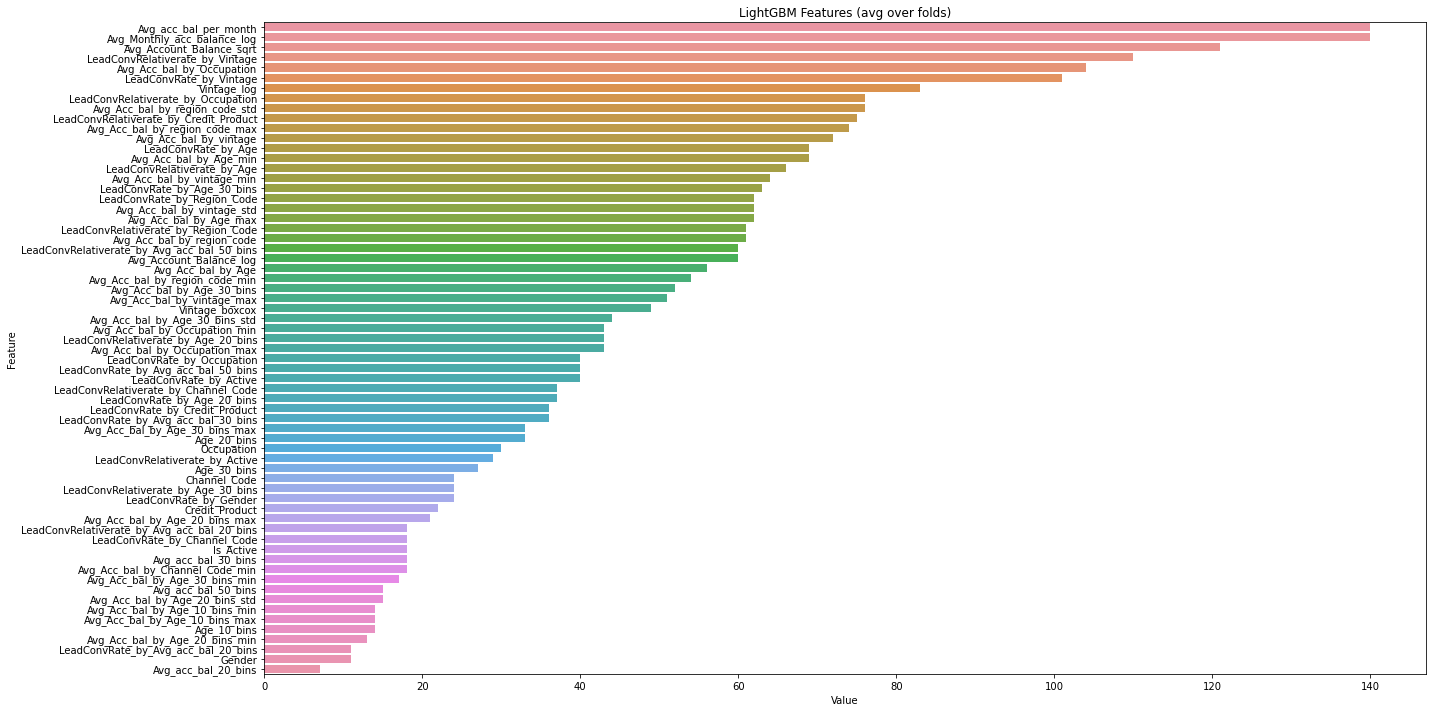

In [2064]:
#params = {'n_estimators': 10000, 'n_jobs': -1, 'random_state': 2,'learning_rate': 0.1,'max_depth': -1,'subsample': 0.63, 'colsample_bytree': 0.55,'metric':'auc'}
res=model(train1[cols],test[cols[:-1]],LGBMClassifier(**params),'rawstdnew11fs',sample_submission)

In [1902]:
import random
n_estimators = [int(x) for x in np.linspace(start = 8000, stop = 15000, num = 1000)]

# Minimum number of samples required to split a node
min_samples_split = np.arange(20,30,1)
# Minimum number of samples required at each leaf node
min_samples_leaf =np.arange(20,30,1)
# Method of selecting samples for training each tree
bootstrap = [False]
# Create the random grid
class_weight=[None,'balanced',{0:1.5,1:1},{0:1,1:1.5}]
params = {'n_estimators': n_estimators,
               'learning_rate': [0,0.1,0.1157,0.0099,0.001],
              'scale_pos_weight':[3.2157,1],
               'max_depth': [-1,10,20,30,40],
              'num_leaves':[10,20],
              'subsample':[random.uniform(0.5,1) for i in range(0,10)],
              'colsample_bytree':[random.uniform(0.45,0.8) for i in range(0,10)]}
lgb=LGBMClassifier(n_jobs=-1,random_state=123,verbose=1)

In [1903]:
X1=train1.drop(columns=['Is_Lead'])
X=pd.DataFrame(MaxAbsScaler().fit(X1).transform(X1),columns=X1.columns)
y=train1['Is_Lead']    

In [1950]:
# grid1=RandomizedSearchCV(lgb, params,cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(X=X[cols[:-1]], y=y),n_iter=10,scoring='roc_auc')
# grid1.fit(X[cols[:-1]], y)
# rf=grid1.best_estimator_

In [1943]:
categorical

['Avg_Acc_bal_by_Age_10_bins_min',
 'Avg_Acc_bal_by_Channel_Code_min',
 'LeadConvRate_by_Gender',
 'Avg_Acc_bal_by_Occupation_max',
 'Avg_Acc_bal_by_Occupation_min',
 'LeadConvRelativerate_by_Active',
 'LeadConvRelativerate_by_Channel_Code',
 'LeadConvRate_by_Active',
 'Channel_Code',
 'LeadConvRelativerate_by_Credit_Product',
 'Gender',
 'Avg_Acc_bal_by_Occupation',
 'LeadConvRate_by_Channel_Code',
 'LeadConvRate_by_Credit_Product',
 'Is_Active',
 'Credit_Product',
 'LeadConvRelativerate_by_Occupation',
 'Occupation',
 'LeadConvRate_by_Occupation']

In [1951]:
# params = {'n_estimators': 1000, 'n_jobs': -1, 'random_state': 2,'learning_rate': 0.1,'max_depth': -1,'subsample': 0.63, 'colsample_bytree': 0.55,'metric':'auc'}
# model(train1[cols],test1[cols[:-1]],LGBMClassifier(**params),'rawstdnew111',sample_submission)

(105312, 55)
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.875466
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.876382
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.874227
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	valid_0's auc: 0.872247
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	valid_0's auc: 0.876152
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[73]	valid_0's auc: 0.871419
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	valid_0's auc: 0.875209
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	val

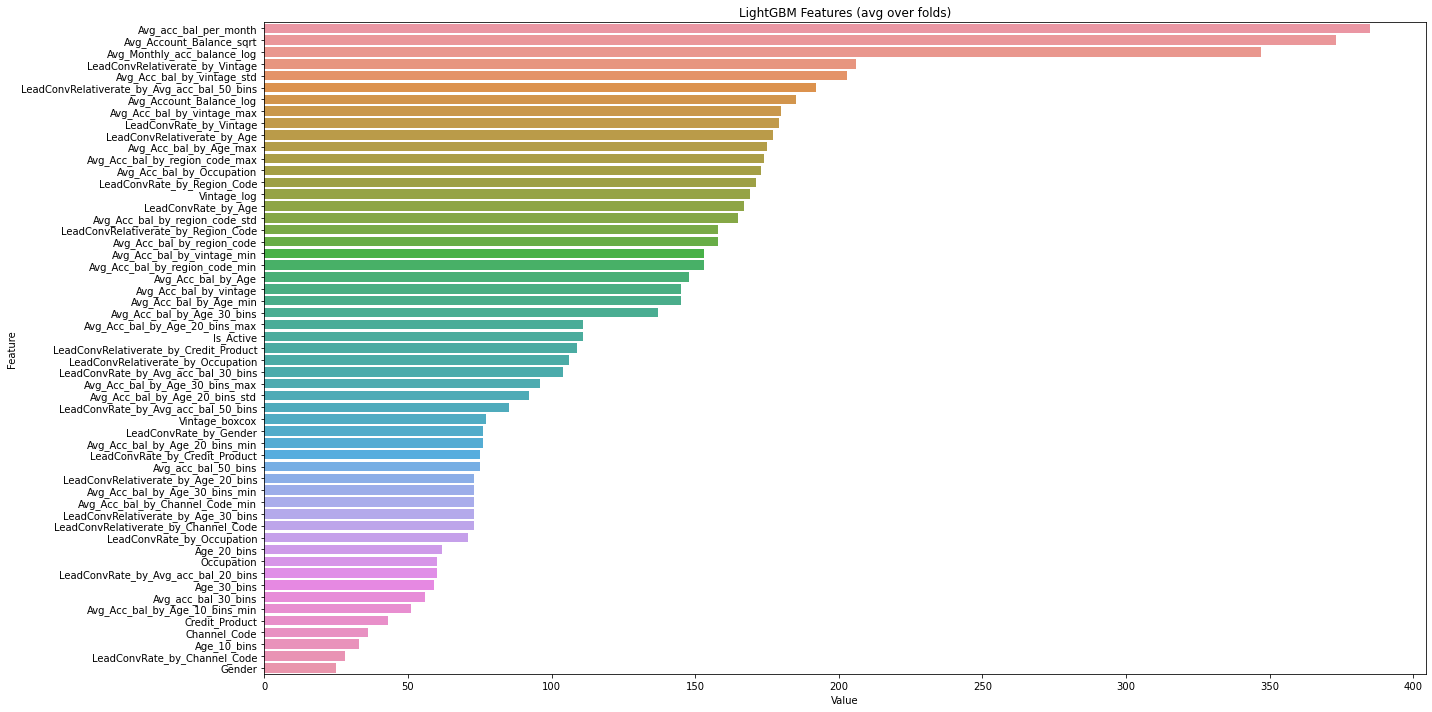

,Value,Feature
0,25,Gender
1,28,LeadConvRate_by_Channel_Code
2,33,Age_10_bins
3,36,Channel_Code
4,43,Credit_Product
5,51,Avg_Acc_bal_by_Age_10_bins_min
6,56,Avg_acc_bal_30_bins
7,59,Age_30_bins
8,60,LeadConvRate_by_Avg_acc_bal_20_bins
9,60,Occupation


In [1869]:
params = {'n_estimators': 10000, 'n_jobs': -1, 'random_state': 2,'learning_rate': 0.1,'max_depth': -1,'subsample': 0.63, 'colsample_bytree': 0.55,'metric':'auc'}
model(train1[cols],test1[cols[:-1]],LGBMClassifier(**params),'rawstdnew11',sample_submission)

In [1794]:
# X=train1.drop(columns=['Is_Lead'])
# y=train1['Is_Lead']

In [54]:
lgb=LGBMClassifier(**params)

In [55]:
# lgb.get_params()

In [1875]:

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, KFold,cross_val_score,StratifiedKFold,cross_validate
def model_cat(train,test,model_name=None,modename='predmodel',sample_submission=pd.DataFrame()):
    pred='Is_Lead'
    predictions = np.zeros(test.shape[0])
    oobs = np.zeros(train.shape[0])
    y = train[pred].values
    skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
    model = model_name
    X=train.drop(columns=['Is_Lead'])
    y=train['Is_Lead']
    X_test=test
    transformer = MaxAbsScaler().fit(X)
    X = transformer.transform(X)
    X_test = transformer.transform(X_test)
    for i, (train_id, valid_id) in enumerate(skf.split(X,y)):
        X_train, y_train = X[train_id], y[train_id]
        X_valid, y_valid = X[valid_id], y[valid_id]
        model.fit(X_train, y_train, eval_set =[(X_valid, y_valid)], verbose=1000,early_stopping_rounds=200)
        oobs[valid_id] = model.predict_proba(X_valid)[:,1]
        predictions += model.predict_proba(X_test)[:,1]
        roc_score = roc_auc_score(y_valid, oobs[valid_id])
        print(roc_score)
    roc_auc = roc_auc_score(y,oobs)
    finals = predictions/10
    print(finals)
    lgb_predictions = finals
    sample_submission[pred] = finals
    print("ROC-AUC", roc_auc)
    lgb_oobs = oobs
    pd.DataFrame(data=oobs).to_csv('oob_lgb.csv')
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,train.drop(columns=['Is_Lead']))), columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    print(feature_imp)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    sample_submission.to_csv('model'+modename+'.csv', index=False)
    return feature_imp

0:	learn: 0.6119377	test: 0.6115284	best: 0.6115284 (0)	total: 99.8ms	remaining: 16m 38s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3414610777
bestIteration = 83

Shrink model to first 84 iterations.
0.8746385965370872
0:	learn: 0.6118963	test: 0.6119054	best: 0.6119054 (0)	total: 108ms	remaining: 18m 2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3411510468
bestIteration = 91

Shrink model to first 92 iterations.
0.8762948479305681
0:	learn: 0.6115629	test: 0.6119512	best: 0.6119512 (0)	total: 105ms	remaining: 17m 29s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3448710949
bestIteration = 75

Shrink model to first 76 iterations.
0.8743746909630399
0:	learn: 0.6117116	test: 0.6119639	best: 0.6119639 (0)	total: 91.3ms	remaining: 15m 12s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3455622529
bestIteration = 99

Shrink model to first 100 iterations.
0.8711029858141555
0:	learn: 0.6114698	te

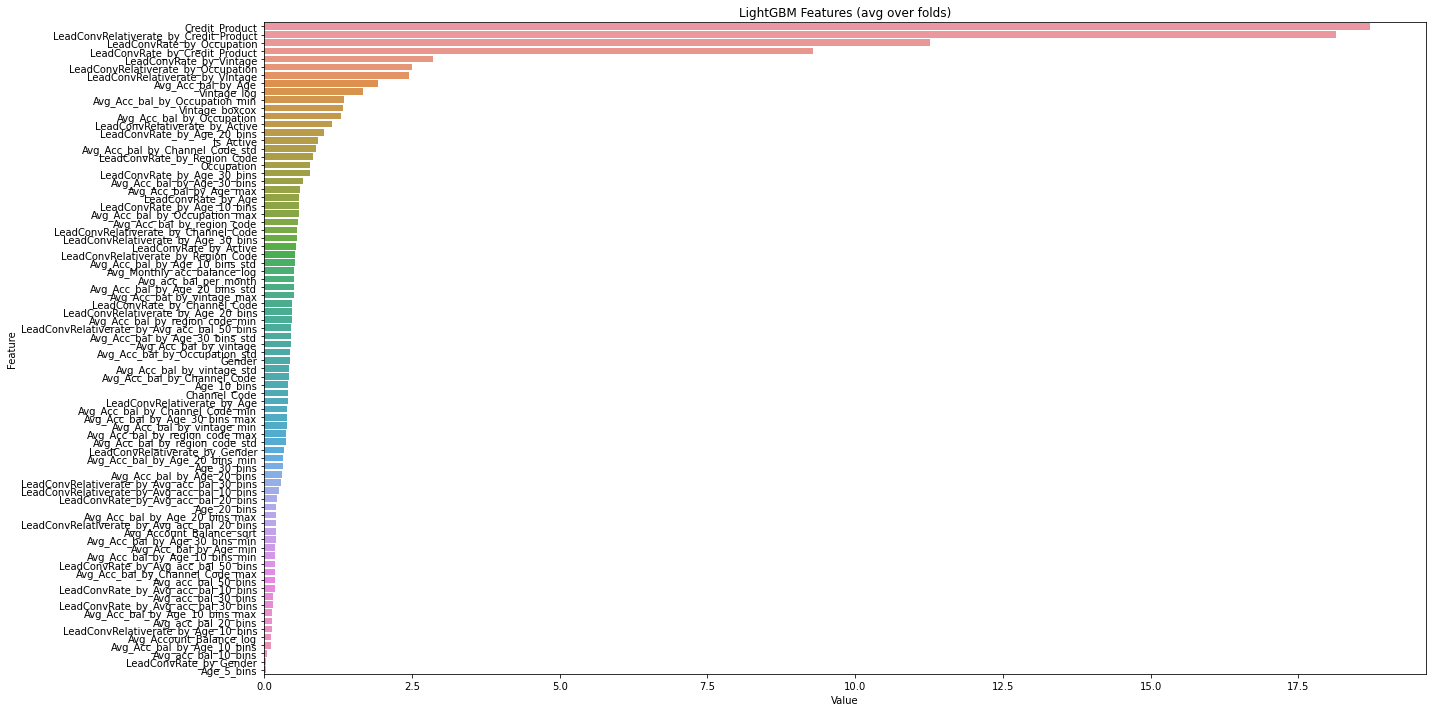

In [1802]:
params= {'n_estimators': 10000, 
                  'depth': 8, 
                  'learning_rate': 0.1, 
                  'colsample_bylevel': 0.55, 
                  'bagging_temperature': 0.9, 
                  'l2_leaf_reg': 10,
        "boosting_type":'Plain',
        "one_hot_max_size":100,
        "max_ctr_complexity":3}
res1=model_cat(train1,test1,CatBoostClassifier(**params),'rawstdnewcat',sample_submission)

In [1876]:
cols1=list(res1[-55:]['Feature'].values)
cols1.append('Is_Lead')

In [1877]:
model_cat(train1[cols1],test1[cols1[:-1]],CatBoostClassifier(**params),'rawCATboost',sample_submission)

TypeError: __init__() got an unexpected keyword argument 'n_jobs'

[21:50:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.63957
[284]	validation_0-logloss:0.34438
0.8748315467125498
[21:51:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.63968
[286]	validation_0-logloss:0.34389
0.876335430482948
[21:51:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was ch

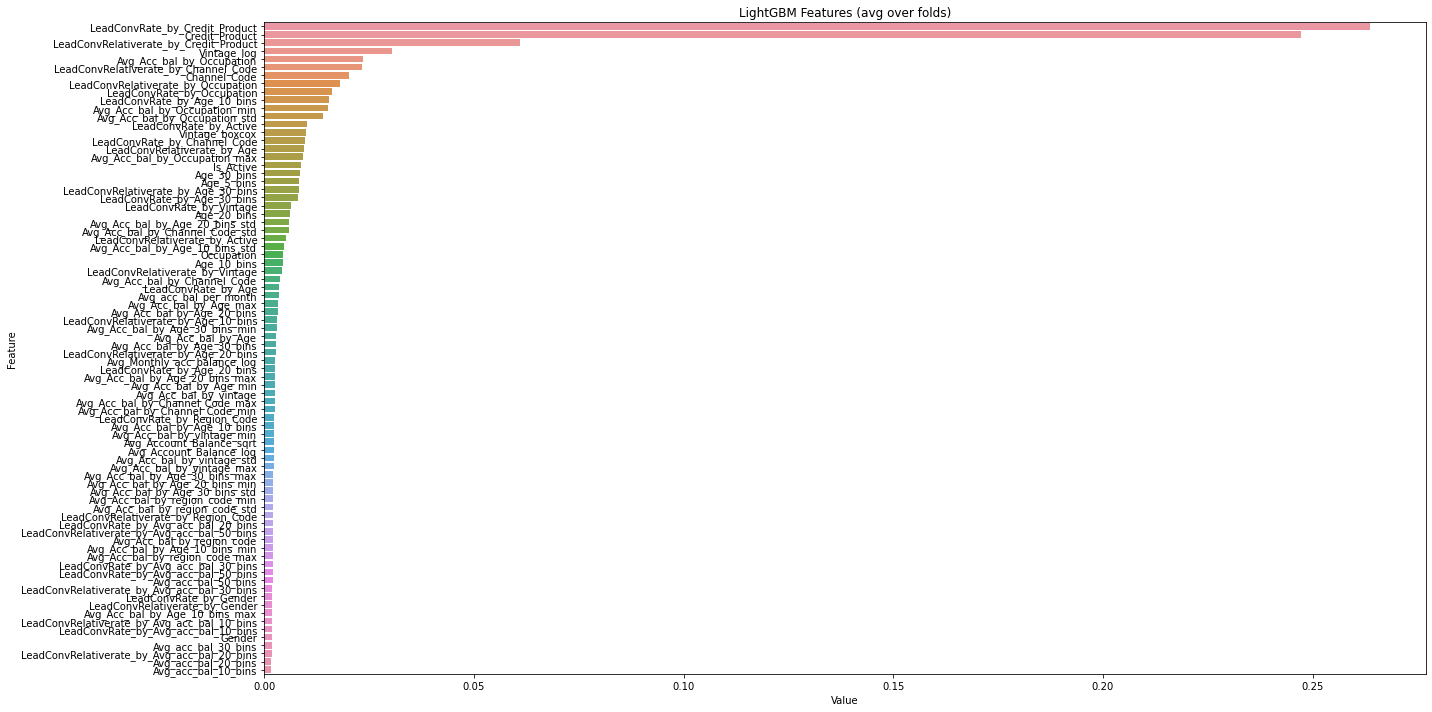

In [1818]:
xgb_params= {'n_estimators': 10000, 
             'max_depth': 8, 
             'eta': 0.1, 
             'reg_lambda': 29.326, 
             'subsample': 0.632, 
             'colsample_bytree': 0.2367, 
             'colsample_bynode': 0.8, 
             'colsample_bylevel': 0.55}
cols2=model_cat(train1,test1,XGBClassifier(**xgb_params),'rawstdxgboost',sample_submission)

In [1829]:
cols_xgb=list(cols2[-60:]['Feature'].values)
cols_xgb.append('Is_Lead')

0:	learn: 0.6129603	test: 0.6128552	best: 0.6128552 (0)	total: 59.2ms	remaining: 9m 52s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3414607582
bestIteration = 69

Shrink model to first 70 iterations.
0.8750354204956498
0:	learn: 0.6116085	test: 0.6115945	best: 0.6115945 (0)	total: 62.2ms	remaining: 10m 21s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.341338172
bestIteration = 74

Shrink model to first 75 iterations.
0.8760813456303043
0:	learn: 0.6115109	test: 0.6115806	best: 0.6115806 (0)	total: 81.4ms	remaining: 13m 33s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3447952911
bestIteration = 105

Shrink model to first 106 iterations.
0.8744533116497664
0:	learn: 0.6127563	test: 0.6132673	best: 0.6132673 (0)	total: 66.6ms	remaining: 11m 6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3454422933
bestIteration = 94

Shrink model to first 95 iterations.
0.8714827630871502
0:	learn: 0.6129573	t

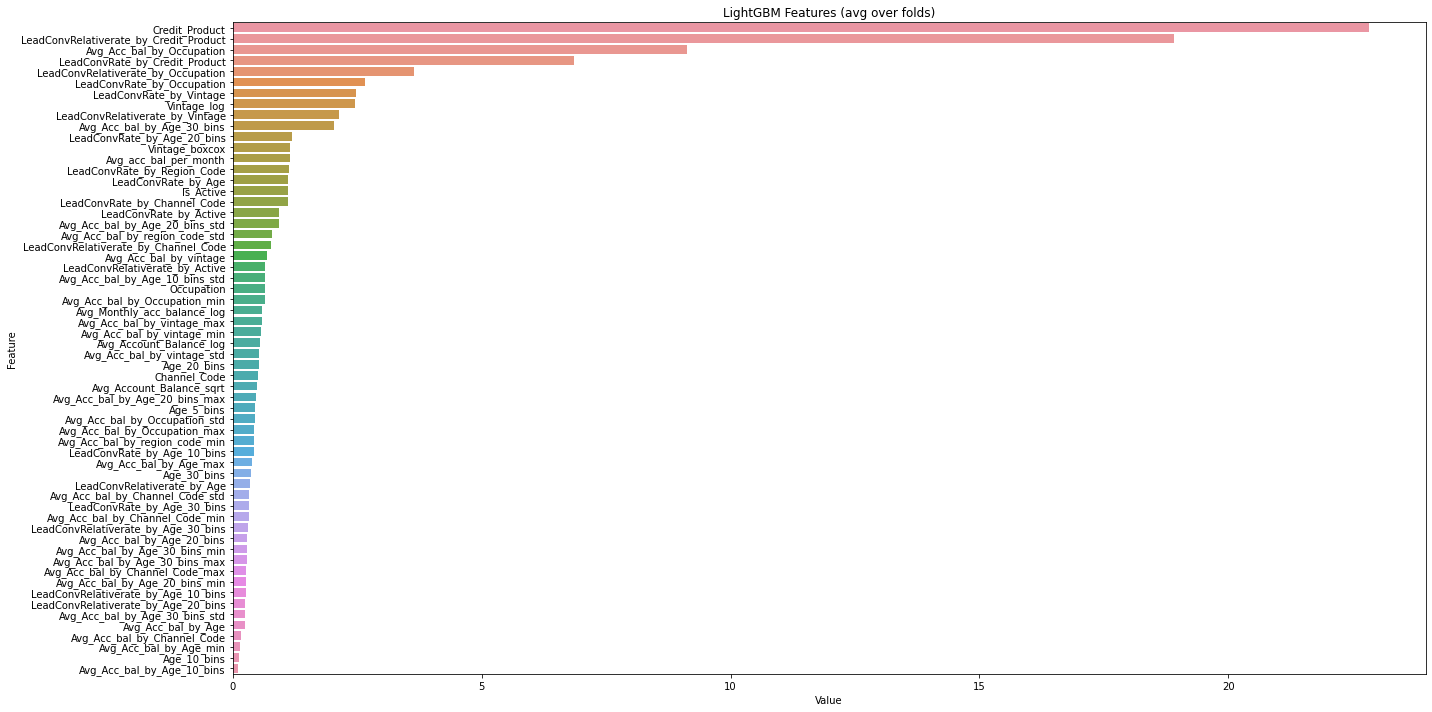

,Value,Feature
0,0.113958,Avg_Acc_bal_by_Age_10_bins
1,0.134067,Age_10_bins
2,0.135014,Avg_Acc_bal_by_Age_min
3,0.157401,Avg_Acc_bal_by_Channel_Code
4,0.235149,Avg_Acc_bal_by_Age
5,0.241642,Avg_Acc_bal_by_Age_30_bins_std
6,0.242276,LeadConvRelativerate_by_Age_20_bins
7,0.264074,LeadConvRelativerate_by_Age_10_bins
8,0.268355,Avg_Acc_bal_by_Age_20_bins_min
9,0.270061,Avg_Acc_bal_by_Channel_Code_max


In [1830]:
model_cat(train1[cols_xgb],test1[cols_xgb[:-1]],CatBoostClassifier(**params),'rawstdnewcat',sample_submission)